In [1]:
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
data = pd.read_csv('datasets/mood_dataset_preprocessed.csv')

In [3]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.game,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel
0,AS14.01,2014-02-26 13:00:00,6.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,AS14.01,2014-02-26 15:00:00,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2,AS14.01,2014-02-26 18:00:00,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AS14.01,2014-02-26 21:00:00,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,AS14.01,2014-02-27 09:00:00,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0


In [4]:
data.fillna(0.0, inplace=True)

In [5]:
data['time'] = pd.to_datetime(data['time'])

In [6]:
result = data.groupby([data['time'].dt.date, 'id']).size().reset_index(name='count')

In [7]:
result

,time,id,count
0,2014-02-26,AS14.01,4
1,2014-02-27,AS14.01,3
2,2014-03-04,AS14.17,2
3,2014-03-05,AS14.08,3
4,2014-03-05,AS14.17,3
...,...,...,...
1263,2014-06-04,AS14.24,4
1264,2014-06-05,AS14.24,5
1265,2014-06-06,AS14.24,4
1266,2014-06-07,AS14.24,1


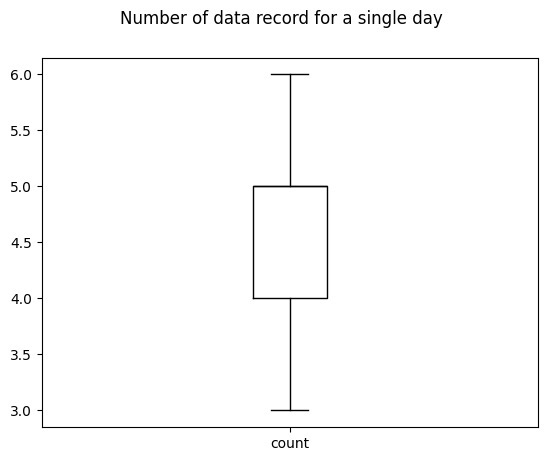

In [8]:
result.boxplot('count', grid=False, showfliers=False, color="black")
plt.suptitle("Number of data record for a single day")
plt.xlabel("")
plt.show()

In [9]:
data["next_mood"] = data.groupby('id')['mood'].shift(-1)

In [10]:
data.head(30)

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,6.0,0.000,0.000,7.0,0.0,0.000000,0.000,0.000,...,0.000,17.0,0.000,0.000,-1.0,0.000000,0.000,0.000,0.000,6.0
1,AS14.01,2014-02-26 15:00:00,6.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,-1.0,0.000000,0.000,0.000,0.000,6.0
2,AS14.01,2014-02-26 18:00:00,6.0,0.000,0.000,1.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.0,0.000000,0.000,0.000,0.000,7.0
3,AS14.01,2014-02-26 21:00:00,7.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,1.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,6.0
4,AS14.01,2014-02-27 09:00:00,6.0,0.000,0.000,1.0,0.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,-2.0,0.000000,0.000,0.000,0.000,6.0
5,AS14.01,2014-02-27 12:00:00,6.0,0.000,0.000,0.0,0.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,7.0
6,AS14.01,2014-02-27 15:00:00,7.0,0.000,0.000,0.0,1.0,0.000000,0.000,0.000,...,0.000,0.0,0.000,0.000,1.0,0.000000,0.000,0.000,0.000,6.0
7,AS14.01,2014-03-21 09:00:00,6.0,2300.541,11.345,10.0,0.0,4793.343000,350.856,0.000,...,0.000,33.0,496.208,0.000,-1.0,0.238190,302.689,45.173,0.000,6.0
8,AS14.01,2014-03-21 11:00:00,6.0,1794.749,38.160,0.0,0.0,4240.973000,403.980,0.000,...,0.000,0.0,587.566,18.196,0.0,0.065054,18.061,0.000,71.305,7.0
9,AS14.01,2014-03-21 15:00:00,7.0,1488.071,70.860,0.0,1.0,5467.570000,287.389,0.000,...,62.281,4.0,979.241,0.000,1.0,1.931720,154.724,0.000,844.140,6.0


In [11]:
average_moods = data.groupby('id')['mood'].mean()
data['next_mood'] = data.apply(
    lambda row: int(average_moods[row['id']]) if pd.isna(row['next_mood']) else int(row['next_mood']),
    axis=1
)

In [12]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,6.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,17.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,6
1,AS14.01,2014-02-26 15:00:00,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,6
2,AS14.01,2014-02-26 18:00:00,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,AS14.01,2014-02-26 21:00:00,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6
4,AS14.01,2014-02-27 09:00:00,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,6


In [13]:
features = ['mood', 'appCat.communication', 'appCat.other', 'sms',
       'circumplex.valence', 'screen', 'appCat.entertainment',
       'appCat.weather', 'appCat.social', 'appCat.game', 'appCat.office',
       'call', 'appCat.builtin', 'appCat.finance', 'circumplex.arousal',
       'activity', 'appCat.utilities', 'appCat.unknown', 'appCat.travel']
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [14]:
data.head()

,id,time,mood,appCat.communication,appCat.other,sms,circumplex.valence,screen,appCat.entertainment,appCat.weather,...,appCat.office,call,appCat.builtin,appCat.finance,circumplex.arousal,activity,appCat.utilities,appCat.unknown,appCat.travel,next_mood
0,AS14.01,2014-02-26 13:00:00,0.555556,0.0,0.0,0.084337,0.6,0.0,0.0,0.0,...,0.0,0.062044,0.7044,0.0,0.4,0.0,0.0,0.0,0.0,6
1,AS14.01,2014-02-26 15:00:00,0.555556,0.0,0.0,0.000000,0.8,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.4,0.0,0.0,0.0,0.0,6
2,AS14.01,2014-02-26 18:00:00,0.555556,0.0,0.0,0.012048,0.8,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.6,0.0,0.0,0.0,0.0,7
3,AS14.01,2014-02-26 21:00:00,0.666667,0.0,0.0,0.000000,0.8,0.0,0.0,0.0,...,0.0,0.003650,0.7044,0.0,0.8,0.0,0.0,0.0,0.0,6
4,AS14.01,2014-02-27 09:00:00,0.555556,0.0,0.0,0.012048,0.6,0.0,0.0,0.0,...,0.0,0.000000,0.7044,0.0,0.2,0.0,0.0,0.0,0.0,6


In [15]:
result = data.groupby([data['time'].dt.date, 'id']).apply(lambda x:  x.drop(columns=['time']).values.tolist(), include_groups=False).reset_index(drop=True)

In [16]:
MAX_LEN = 5

In [17]:
predictions = []
results = []

for single_data in result:
    if len(single_data) < MAX_LEN:
        n_fill = MAX_LEN - len(single_data)
        predictions.append(int(single_data[-1][-1]))
        while n_fill:
            single_data.append([0.0]*20)
            n_fill -= 1
    else:
        single_data = single_data[:MAX_LEN]
        predictions.append(int(single_data[-1][-1]))
    
    for single_record in single_data:
        del single_record[-1]
    
    results.append(single_data[:])    

In [18]:
for i in results:
    if len(i) != 5:
        print(len(i))

In [19]:
predictions = [i - 1 for i in predictions]

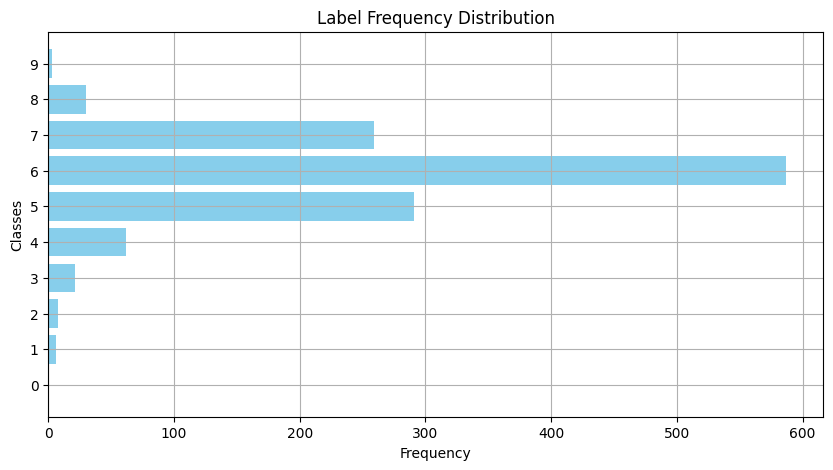

In [20]:
counter = Counter(predictions).most_common()
class_names = []
frequencies = []

for name, count in counter:
    class_names.append(name)
    frequencies.append(count)

plt.figure(figsize=(10, 5))
plt.barh(class_names, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Classes')
plt.yticks(range(10))
plt.title('Label Frequency Distribution')
plt.grid(True)
plt.show()

In [21]:
len(set(predictions))

10

In [22]:
data_tensor = torch.tensor(results, dtype=torch.float32)
labels_tensor = torch.tensor(predictions, dtype=torch.long)

dataset = TensorDataset(data_tensor, labels_tensor)

In [23]:
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

In [24]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [25]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
class MoodLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MoodLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output dimension is 10 for 10 classes
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [27]:
model = MoodLSTMClassifier(input_dim=19, hidden_dim=10, num_layers=1, output_dim=10)

In [28]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class problems
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [29]:
model.train()

for epoch in range(100):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # No need to squeeze or convert labels
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 2.317159652709961
Epoch 1, Loss: 2.303766965866089
Epoch 1, Loss: 2.2972583770751953
Epoch 1, Loss: 2.2547800540924072
Epoch 1, Loss: 2.22198486328125
Epoch 1, Loss: 2.190105676651001
Epoch 1, Loss: 2.1717495918273926
Epoch 1, Loss: 2.0653228759765625
Epoch 1, Loss: 2.0610837936401367
Epoch 1, Loss: 2.051931381225586
Epoch 1, Loss: 1.9942646026611328
Epoch 1, Loss: 1.9801700115203857
Epoch 1, Loss: 1.8036822080612183
Epoch 1, Loss: 1.8702200651168823
Epoch 1, Loss: 1.788832187652588
Epoch 1, Loss: 1.6400017738342285
Epoch 2, Loss: 1.6173720359802246
Epoch 2, Loss: 1.7267470359802246
Epoch 2, Loss: 1.6573370695114136
Epoch 2, Loss: 1.6063783168792725
Epoch 2, Loss: 1.4764653444290161
Epoch 2, Loss: 1.4404102563858032
Epoch 2, Loss: 1.4772576093673706
Epoch 2, Loss: 1.7087352275848389
Epoch 2, Loss: 1.4308550357818604
Epoch 2, Loss: 1.479441523551941
Epoch 2, Loss: 1.714840292930603
Epoch 2, Loss: 1.280116319656372
Epoch 2, Loss: 1.5241984128952026
Epoch 2, Loss: 1.5017462

In [30]:
model.eval()  # Set the model to evaluation mode
all_predictions = [] 
all_labels = []
with torch.no_grad():  # No gradient tracking needed
    correct, total = 0, 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Thresholding at 0.5
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
    print(f'Accuracy: {100 * correct / total}%')


Accuracy: 47.24409448818898%


In [31]:
def plot_confusion_matrix(y_p, y_t, labels):
    cm =  confusion_matrix(y_t, y_p, normalize='true', labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

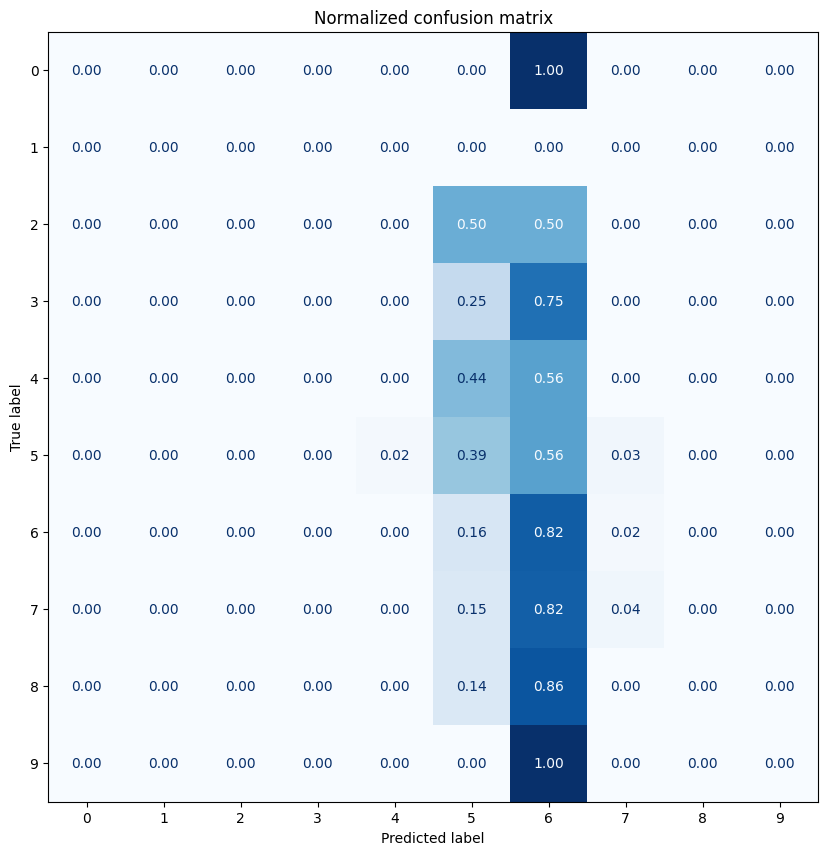

In [32]:
plot_confusion_matrix(all_predictions, all_labels, [i for i in range(10)])